### Taking PDF/Image Input using FAST API

In [ ]:
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import JSONResponse

app = FastAPI(title="Marksheet Extraction API")

allowed_types = {
    "application/pdf",
    "image/jpeg",
    "image/jpg"
    "image/png"
}

max_file_size = 10 * 1024 * 1024    # 10mb

@app.post("/extract")
async def extract_marksheet(file: UploadFile = File(...)):

    if file.content_type not in allowed_types:
        raise HTTPException(status_code=400, detail="Invalid file type. Only PDF, JPG, PNG allowed.")

    contents = await file.read()

    if(len(contents) > max_file_size):
        raise HTTPException(status_code=400, detail="File size exceeds 10 MB limit.")

    return JSONResponse(content={
        "status":"success",
        "filename":file.filename,
        "filetype":file.content_type,
        "message":"File recieved successfully"
    })

### Converting pdf to image

In [ ]:
from pdf2image import convert_from_bytes
from PIL import Image
from typing import List

def pdf_to_image(pdf_bytes: bytes) -> List[Image.Image]:

    images = convert_from_bytes(pdf_bytes, dpi=300, fmt="png")
    return images

# integrating both 

if file.content_type == "application/pdf":
    images = pdf_to_image(contents)
else:
    image: Image.open(io.BytesIO(contents))
    images = [image]

### Optical Character Recognition (OCR)
Raw data parsing from image 

In [ ]:
import pytesseract
from pytesseract import Output
from PIL import Image
from typing import Dict

def extract_text_from_image(image: Image.Image) -> Dict:
    
    ocr_data = pytesseract.image_to_data(image, output_type=Output.DICT)
    
    words = []
    confidences = []

    for i in range(len(ocr_data["text"])):
        text = ocr_data["text"][i].strip()
        conf = int(ocr_data["conf"][i])

        if (text and conf>0):
            words.append(text)
            confidences.append(conf)

    full_text = " ".join(words)
    avg_confidence = sum(confidences)/len(confidences) if confidences else 0

    return {
        "text": full_text,
        "ocr_confidence":round(avg_confidence/100, 2)
    }

def extract_text_from_images(images):
    page_results = []

    for page_no, image in enumerate(images, start=1):
        result = extract_text_from_image(image)
        page_results.append({
            "page": page_no,
            "text": result["text"],
            "ocr_confidence": result["ocr_confidence"]
        })

    return page_results

### LangGraph implementation

In [11]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, List, Dict, Any, Optional
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import datetime
import os

In [4]:
class WorkflowState(TypedDict, total=False):
    # Input
    ocr_pages: List[Dict[str, Any]]  # [{page, text, ocr_confidence}]

    # Intermediate
    extracted_data: Dict[str, Any]
    validated_data: Dict[str, Any]

    # Output
    final_result: Dict[str, Any]


In [5]:
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", api_key=GOOGLE_API_KEY)

In [8]:
class CandidateDetails(BaseModel):
    name: Optional[str] = Field(description="Full name of the candidate")
    father_or_mother_name: Optional[str] = Field(description="Father's or Mother's name")
    roll_number: Optional[str] = Field(description="Roll number of the candidate")
    registration_number: Optional[str] = Field(description="Registration number of the candidate")
    date_of_birth: Optional[str] = Field(description="Date of birth of the candidate")
    exam_year: Optional[str] = Field(description="Year of examination")
    board_or_university: Optional[str] = Field(description="Board or University name")
    institution: Optional[str] = Field(description="School or College name")


class SubjectMarks(BaseModel):
    subject_name: str = Field(description="Name of the subject")
    max_marks_or_credits: Optional[float] = Field(description="Maximum marks or credits")
    obtained_marks_or_credits: Optional[float] = Field(description="Marks or credits obtained by the candidate")
    grade: Optional[str] = Field(description="Grade if mentioned")


class OverallResult(BaseModel):
    result_or_division: Optional[str] = Field(description="Pass/Fail/Division")
    overall_grade: Optional[str] = Field(description="Overall grade if present")


class IssueDetails(BaseModel):
    issue_date: Optional[str] = Field(description="Date of issue of marksheet")
    issue_place: Optional[str] = Field(description="Place of issue of marksheet")


class MarksheetExtraction(BaseModel):
    candidate_details: CandidateDetails
    subjects: List[SubjectMarks]
    overall_result: OverallResult
    issue_details: IssueDetails


In [9]:
structured_model = model.with_structured_output(MarksheetExtraction)

In [ ]:
def normalize_date(date_str: str) -> str | None:
    """
    Normalize dates into YYYY-MM-DD format if possible
    """
    if not date_str:
        return None

    for fmt in ("%d-%m-%Y", "%d/%m/%Y", "%Y-%m-%d", "%d %b %Y"):
        try:
            return datetime.strptime(date_str.strip(), fmt).date().isoformat()
        except ValueError:
            continue

    return None


def safe_float(value):
    try:
        return float(value)
    except (TypeError, ValueError):
        return None

In [13]:
def extraction_node(state: WorkflowState) -> WorkflowState:
    pages = state["ocr_pages"]

    combined_text = "\n".join(
        page["text"] for page in pages
    )

    response = structured_model.invoke(combined_text)

    extracted_data = {
        "candidate_details": response.candidate_details,
        "subjects": response.subjects,
        "overall_result": response.overall_result,
        "issue_details": response.issue_details
    }

    state["extracted_data"] = extracted_data
    return state

def validation_node(state: WorkflowState) -> WorkflowState:
    extracted = state.get("extracted_data", {})

    validated: dict = {}

    # -------------------------
    # Candidate Details
    # -------------------------
    candidate = extracted.get("candidate_details", {})

    validated["candidate_details"] = {
        "name": candidate.get("name"),
        "father_or_mother_name": candidate.get("father_or_mother_name"),
        "roll_number": candidate.get("roll_number"),
        "registration_number": candidate.get("registration_number"),
        "exam_year": candidate.get("exam_year"),
        "board_or_university": candidate.get("board_or_university"),
        "institution": candidate.get("institution"),
        "date_of_birth": normalize_date(candidate.get("date_of_birth"))
    }

    # -------------------------
    # Subjects
    # -------------------------
    validated_subjects = []

    for subject in extracted.get("subjects", []):
        subject_name = subject.get("subject_name")
        if not subject_name:
            continue

        max_marks = safe_float(subject.get("max_marks_or_credits"))
        obtained_marks = safe_float(subject.get("obtained_marks_or_credits"))

        if max_marks is not None and obtained_marks is not None:
            if obtained_marks > max_marks:
                obtained_marks = None

        validated_subjects.append({
            "subject_name": subject_name.strip(),
            "max_marks_or_credits": max_marks,
            "obtained_marks_or_credits": obtained_marks,
            "grade": subject.get("grade")
        })

    validated["subjects"] = validated_subjects

    # -------------------------
    # Overall Result
    # -------------------------
    overall = extracted.get("overall_result", {})

    validated["overall_result"] = {
        "result_or_division": overall.get("result_or_division"),
        "overall_grade": overall.get("overall_grade")
    }

    # -------------------------
    # Issue Details
    # -------------------------
    issue = extracted.get("issue_details", {})

    validated["issue_details"] = {
        "issue_date": normalize_date(issue.get("issue_date")),
        "issue_place": issue.get("issue_place")
    }

    state["validated_data"] = validated
    return state

def confidence_node(state: WorkflowState) -> WorkflowState:
    validated_data = state["validated_data"]

    pages = state["ocr_pages"]
    avg_ocr_conf = sum(
        p["ocr_confidence"] for p in pages
    ) / len(pages)

    def wrap(value, base_conf=avg_ocr_conf):
        return {
            "value": value,
            "confidence": round(base_conf, 2)
        }

    final_result = {
        "candidate_details": {},
        "subjects": [],
        "overall_result": {},
        "issue_details": {}
    }

    for section, fields in validated_data.items():
        if isinstance(fields, dict):
            final_result[section] = {
                k: wrap(v) for k, v in fields.items()
            }
        elif isinstance(fields, list):
            for item in fields:
                wrapped_item = {
                    k: wrap(v) for k, v in item.items()
                }
                final_result[section].append(wrapped_item)

    state["final_result"] = final_result
    return state


In [14]:
def build_graph():
    graph = StateGraph(WorkflowState)

    graph.add_node("extract", extraction_node)
    graph.add_node("validate", validation_node)
    graph.add_node("confidence", confidence_node)

    graph.add_edge(START, "extract")
    graph.add_edge("extract", "validate")
    graph.add_edge("validate", "confidence")
    graph.add_edge("confidence", END)

    return graph.compile()

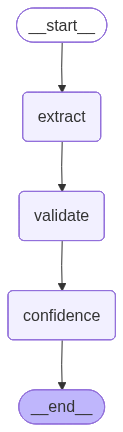

In [15]:
build_graph()

In [ ]:
initial_state = {
    "ocr_pages": [
        {"page": 1, "text": "...", "ocr_confidence": 0.91}
    ]
}

result_state = graph.invoke(initial_state)

response = result_state["final_result"]